Wandb Report Link: 
https://wandb.ai/drbean/MLP-regression/reports/Question-3--Vmlldzo1NzkwOTM2

In [1]:
import sys
import wandb
import warnings
import numpy as np
import pandas as pd

from prettytable import PrettyTable
from matplotlib import pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

warnings.filterwarnings('ignore')
np.set_printoptions(threshold=sys.maxsize)

In [2]:
data = pd.read_csv('HousingData.csv')
data.drop_duplicates(inplace=True)
# print(data.shape)

# Dataset Analysis and Preprocessing
columns = data.columns
t = PrettyTable(['Attribute', 'Mean', 'Standard Deviation', 'min Value', 'max value'])
for attr in columns:
    col = data[attr]
    mean = round(col.mean(), 4)
    std = round(col.std(), 4)
    t.add_row([attr, mean, std, col.min(), col.max()])
print(t)

+-----------+----------+--------------------+-----------+-----------+
| Attribute |   Mean   | Standard Deviation | min Value | max value |
+-----------+----------+--------------------+-----------+-----------+
|    CRIM   |  3.6119  |       8.7202       |  0.00632  |  88.9762  |
|     ZN    | 11.2119  |      23.3889       |    0.0    |   100.0   |
|   INDUS   |  11.084  |       6.8359       |    0.46   |   27.74   |
|    CHAS   |   0.07   |       0.2553       |    0.0    |    1.0    |
|    NOX    |  0.5547  |       0.1159       |   0.385   |   0.871   |
|     RM    |  6.2846  |       0.7026       |   3.561   |    8.78   |
|    AGE    | 68.5185  |      27.9995       |    2.9    |   100.0   |
|    DIS    |  3.795   |       2.1057       |   1.1296  |  12.1265  |
|    RAD    |  9.5494  |       8.7073       |     1     |     24    |
|    TAX    | 408.2372 |      168.5371      |    187    |    711    |
|  PTRATIO  | 18.4555  |       2.1649       |    12.6   |    22.0   |
|     B     | 356.67

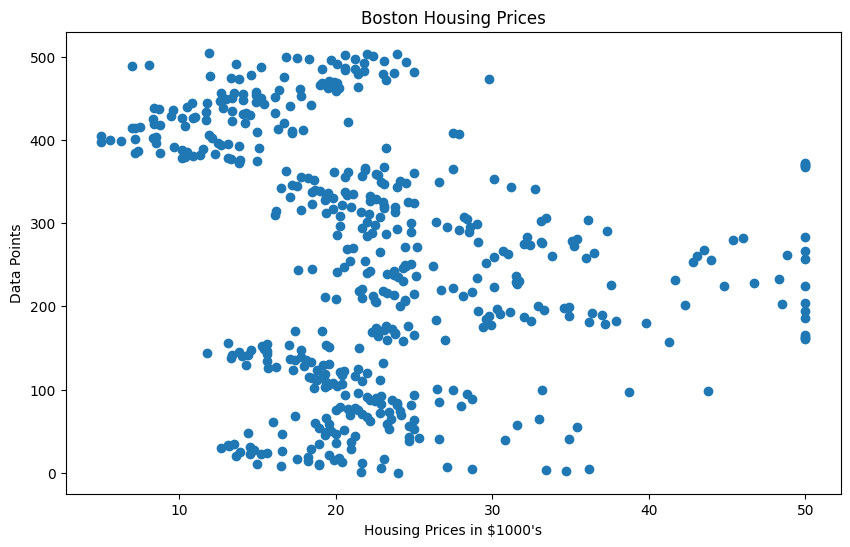

In [3]:
# Distribution of various labels across the entire dataset
labels = data['MEDV']
plt.figure(figsize=(10, 6))
plt.scatter(labels, range(len(labels)))
plt.ylabel('Data Points')
plt.xlabel('Housing Prices in $1000\'s')
plt.title('Boston Housing Prices')
plt.show()

In [ ]:
# Split the data into attributes and labels
X = data.iloc[:,data.columns != 'MEDV']
Y = np.array(data['MEDV']).reshape(-1, 1)

# Handle missing values
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
X = imputer.fit_transform(X)

# Apply Normalization to the attributes
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Apply Standardization to the attributes
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the data into train, test and validation sets
x_train, x_temp, y_train, y_temp = train_test_split(X, Y, train_size=0.7)
x_valid, x_test, y_valid, y_test = train_test_split(x_temp, y_temp, test_size=0.5)

In [5]:
class Network:
    def __init__(self, layers, activation, learn_rate=0.001):
        self.weights = []
        self.bias = []
        self.num = len(layers)-1
        self.batch_size = 1
        self.layers = layers
        self.func = activation
        self.rate = learn_rate
        
        for i in range(len(layers)-1):
            w = np.random.rand(layers[i], layers[i+1])
            self.weights.append(w / np.sqrt(layers[i]))
            self.bias.append(np.zeros((1, layers[i+1])))
        
    def set_activation(self, activation):
        self.func = activation

    def set_learn_rate(self, learn_rate):
        self.rate = learn_rate

    def set_algorithm(self, algorithm):
        self.batch_size = algorithm[1]
    
    def activation(self, x):
        if self.func == 'sigmoid':
            return 1 / (1 + np.exp(-x))
        if self.func == 'tanh':
            return np.tanh(x)
        if self.func == 'ReLU':
            return np.maximum(0, x)
        
    def activation_gradient(self, x):
        if self.func == 'sigmoid':
            return np.exp(-x) / ((1 + np.exp(-x))**2)
        if self.func == 'tanh':
            return 1 - np.tanh(x)**2
        if self.func == 'ReLU':
            return np.where(x > 0, 1, 0)
        
    def batch(self, X, Y):
        n = self.batch_size
        for idx in range(0, len(X), n):
            yield X[idx:min(idx+n, len(X))], Y[idx:min(idx+n, len(X))]
        
    def fit(self, x_train, y_train, n_epochs=1000):
        for _ in range(n_epochs):
            for (x_batch, y_batch) in self.batch(x_train, y_train):
                self.fit_instant(x_batch, y_batch)

    def fit_wandb(self, x_train, y_train, x_valid, y_valid, n_epochs=1000):
        for _ in range(n_epochs):
            for (x_batch, y_batch) in self.batch(x_train, y_train):
                self.fit_instant(x_batch, y_batch)
            y_pred = self.predict(x_valid)
            loss = self.calculate_loss(y_valid, y_pred)
            wandb.log({"MSE": loss[0], "RMSE": loss[1], "R-squared": loss[2]})

    def fit_instant(self, x, y):
        # forward pass
        y_pred, z_pred = [x], [np.zeros_like(x)]
        for layer in range(self.num):
            z = np.dot(y_pred[layer], self.weights[layer]) + self.bias[layer]
            if layer==self.num-1: y_pred.append(z)
            else: y_pred.append(self.activation(z))
            z_pred.append(z)

        # backward pass
        error = (y_pred[-1]-y) / self.batch_size
        derivatives = [error]
        for layer in range(self.num-1, 0, -1):
            delta = np.dot(derivatives[-1], self.weights[layer].T)
            delta = delta * self.activation_gradient(z_pred[layer])
            delta = delta / self.batch_size
            derivatives.append(delta)

        # update the weights
        derivatives = derivatives[::-1]
        for layer in range(self.num):
            self.weights[layer] += -self.rate * np.dot(y_pred[layer].T, derivatives[layer])
            self.bias[layer] += -self.rate * np.sum(derivatives[layer], axis=0, keepdims=True)

    def calculate_loss(self, y_true, y_pred):
        mse = mean_squared_error(y_true, y_pred)
        rmse = mean_squared_error(y_true, y_pred, squared=False)
        r2 = r2_score(y_true, y_pred)
        return [round(mse, 4), round(rmse, 4), round(r2, 4)]
    
    def predict(self, x):
        values = [x]
        for layer in range(self.num):
            z = np.dot(values[layer], self.weights[layer]) + self.bias[layer]
            if layer==self.num-1: values.append(z)
            else: values.append(self.activation(z))
        return values[-1]

In [6]:
def get_nodes(num, mini, maxi):
    layer = []
    layer.append(x_train.shape[1])
    for _ in range(num):
        k = np.random.randint(mini, maxi)
        layer.append(k)
    layer.append(1)
    return layer

In [7]:
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: aahalhalli (drbean). Use `wandb login --relogin` to force relogin


True

In [8]:
losses = ['mse', 'rmse', 'r-squared']
activations = ['sigmoid', 'tanh', 'ReLU']
algorithms = [['SGD', 1], ['BGD', x_train.shape[0]], ['MBGD', 32]]

t =PrettyTable(['Activation', 'Optimizer', 'MSE', 'RMSE', 'R-squared'])
for activation in activations:
    for algo in algorithms:
        str = 'act:{} opt:{}'.format(activation, algo[0])
        wandb.init(project="MLP-regression", config={"activation": activation, "optimizer": algo[0]}, name=str)
        layer = get_nodes(5, 10, 11)
        model = Network(layer, activation, 0.01)
        model.set_algorithm(algo)
        model.fit_wandb(x_train, y_train, x_valid, y_valid, 1000)

        y_pred = model.predict(x_valid)
        scores = model.calculate_loss(y_valid, y_pred)
        t.add_row([activation, algo[0]]+scores)
        wandb.finish()
print(t)

MSE,█▁▁▁▁▁▁▁▁▁▁▁▁▂▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▂▂▂▂▂▂▂
R-squared,▁████████████▇█▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇▇▇▇▇▇▇▇▇▇
RMSE,█▂▂▁▂▂▂▁▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
MSE,14.0694
R-squared,0.8255
RMSE,3.7509


MSE,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
R-squared,▁███████████████████████████████████████
RMSE,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MSE,80.8411
R-squared,-0.0028
RMSE,8.9912


MSE,████▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁
R-squared,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█████████████
RMSE,████▇▇▇▇▇▇▇▆▆▆▆▆▆▄▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁
MSE,80.815
R-squared,-0.0025
RMSE,8.9897


MSE,█▂▃▃▆▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▂▂▂▂▁▁
R-squared,▁▇▆▆▃▆▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇▇▇▇▇▇▇██
RMSE,█▂▃▃▇▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▂▂▂▂▁▁
MSE,34.7202
R-squared,0.5693
RMSE,5.8924


MSE,█▅▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
R-squared,▁▄▆▆▇▇██████████████████████████████████
RMSE,█▆▄▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MSE,64.5522
R-squared,0.1992
RMSE,8.0344


MSE,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
R-squared,▁███████████████████████████████████████
RMSE,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MSE,65.5407
R-squared,0.187
RMSE,8.0957


MSE,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
R-squared,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
RMSE,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MSE,80.6155
R-squared,-0.0
RMSE,8.9786


MSE,█▆▅▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
R-squared,▁▃▄▅▆▇▇▇████████████████████████████████
RMSE,█▇▅▄▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MSE,69.6584
R-squared,0.1359
RMSE,8.3462


MSE,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
R-squared,▁███████████████████████████████████████
RMSE,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MSE,67.194
R-squared,0.1665
RMSE,8.1972


+------------+-----------+---------+--------+-----------+
| Activation | Optimizer |   MSE   |  RMSE  | R-squared |
+------------+-----------+---------+--------+-----------+
|  sigmoid   |    SGD    | 14.0694 | 3.7509 |   0.8255  |
|  sigmoid   |    BGD    | 80.8411 | 8.9912 |  -0.0028  |
|  sigmoid   |    MBGD   |  80.815 | 8.9897 |  -0.0025  |
|    tanh    |    SGD    | 34.7202 | 5.8924 |   0.5693  |
|    tanh    |    BGD    | 64.5522 | 8.0344 |   0.1992  |
|    tanh    |    MBGD   | 65.5407 | 8.0957 |   0.187   |
|    ReLU    |    SGD    | 80.6155 | 8.9786 |    -0.0   |
|    ReLU    |    BGD    | 69.6584 | 8.3462 |   0.1359  |
|    ReLU    |    MBGD   |  67.194 | 8.1972 |   0.1665  |
+------------+-----------+---------+--------+-----------+


In [15]:
learn_rate = [0.1, 0.01, 0.001]
hidden_layers = [10, 25, 50]
epochs = [100, 1000]

t = PrettyTable(['#Epochs', 'Learning Rate', 'Hidden neurons', 'MSE', 'RMSE', 'R-squared'])
for n_epochs in epochs:
    for rate in learn_rate:
        for layer in hidden_layers:
            layers = get_nodes(5, layer, layer+1)
            model = Network(layers, 'sigmoid', rate)
            model.fit(x_train, y_train, n_epochs)

            y_pred = model.predict(x_valid)
            scores = model.calculate_loss(y_valid, y_pred)
            t.add_row([n_epochs, rate, layer]+scores)
print(t)

+---------+---------------+----------------+---------+--------+-----------+
| #Epochs | Learning Rate | Hidden neurons |   MSE   |  RMSE  | R-squared |
+---------+---------------+----------------+---------+--------+-----------+
|   100   |      0.1      |       10       | 83.8452 | 9.1567 |  -0.0401  |
|   100   |      0.1      |       25       | 83.8459 | 9.1567 |  -0.0401  |
|   100   |      0.1      |       50       |  81.159 | 9.0088 |  -0.0068  |
|   100   |      0.01     |       10       | 15.4947 | 3.9363 |   0.8078  |
|   100   |      0.01     |       25       |  9.8859 | 3.1442 |   0.8774  |
|   100   |      0.01     |       50       | 81.5305 | 9.0294 |  -0.0114  |
|   100   |     0.001     |       10       | 76.9793 | 8.7738 |   0.0451  |
|   100   |     0.001     |       25       | 80.4956 | 8.9719 |   0.0015  |
|   100   |     0.001     |       50       | 80.6777 | 8.9821 |  -0.0008  |
|   1000  |      0.1      |       10       | 83.8452 | 9.1567 |  -0.0401  |
|   1000  | 